In this notebook, we apply the attacks on graph datasets, but use the optimization where we train a classifier which observes the dataset and target record to make a decision. This is crucial, as graph generation methods are extremely computationally expensive to run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tqdm

import tapas.datasets
import tapas.generators
import tapas.threat_models
import tapas.attacks

In [2]:
np.random.seed(420)

## Real-world private datasets

The COLLAB dataset contains collaboration networks of academics. They are ego networks for these academics.

In [3]:
data = tapas.datasets.TUDataset.read("deezer_ego_nets", "deezer_ego_nets")

Loading TU graph dataset: deezer_ego_nets


## Memoized kernels

In our attacks, the main blocker is that kernels are computed many times over the same graph, leading to massive performance overheads. Memoization is the key here.

Importantly, we do not check whether graphs are identical, but merely whether they are stored in the same location in memory.

We also use this class to provide a clean interface between grakel kernels and networkx data.

In [4]:
import networkx as nx
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [5]:
class Memoize:
    def __init__(self, kernel):
        self.kernel = kernel
        self.memory = {}
    
    def fit(self, tudataset):
        self.memory = {}  # Fitting the kernel resets the memory.
        self.kernel.fit(_grak(tudataset.data))

    def transform(self, tudataset):
        # Use G for the key, and grak(G) for the feature transformation.
        for G in tudataset.data:
            if G not in self.memory:
                self.memory[G] = self.kernel.transform(_grak([G]))[0]
        return np.stack([self.memory[G] for G in tudataset.data])

    def fit_transform(self, tudataset):        
        self.fit(tudataset)
        return self.transform(tudataset)

We now instantiate a typical kernel.

In [6]:
from grakel import WeisfeilerLehman, VertexHistogram

kernel = Memoize(
    WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
)

## Threat modelling (typical TAPAS)

We attack the Raw generator, for simplicity. This should be trivially attackable!

In [7]:
import pandas as pd

In [8]:
generator = tapas.generators.Raw()

We can adapt the threat model to have every record be a target.

In [9]:
size_private_dataset = 100
# size_synthetic_dataset = 100

In [10]:
# If the private dataset is of size K, choose 2K users at random to serve as target.
sample_data = data.sample(2*size_private_dataset)

In [11]:
threat_model = tapas.threat_models.TargetedMIA(
    # EXACT KNOWLEDGE OF THE "REST" OF THE DATA: auxiliary data is empty.
    attacker_knowledge_data=tapas.threat_models.ExactDataKnowledge(sample_data.empty()),
    # Assume black-box knowledge
    attacker_knowledge_generator=tapas.threat_models.BlackBoxKnowledge(
        generator, num_synthetic_records=None,  # Use the input size as output size.
    ),
    # *All* records are in the data.
    target_record=sample_data,
    generate_pairs=True,  # So has to have both labels.
    replace_target=False,
)

In [12]:
num_train = 100
num_test = 100

In [13]:
# Do all the generation now (it's memoized anyway).
# The train and test distributions are the same here, so we only use training samples for simplicity.
threat_model.generate_training_samples(num_train + num_test);

#### Trained kernel

We use a fraction of the auxiliary dataset exclusively to fit the kernel. It is then discarded.

**Option 1**: Choose a random subset of records to use in the kernel.

In [14]:
kernel_training_data = data.create_subsets(n=1, sample_size = 100, drop_records = True)[0]

**Option 2**: Choose the training set (overfitting?).

In [15]:
# kernel_training_data = sample_data

In [16]:
kernel.fit(kernel_training_data);

## Naive Attack

We implement a classifier $\mathcal{C}_\theta(D,t)$, which we define as $\mathcal{C}_\theta = F_\theta \circ (k\circ join, k)$ where $F_\theta$ is a (trainable) classifier, typically a random forest, $k$ is a (fixed) kernel, and $join$ is the operator grouping the graphs in a dataset $D$ as one large disjointed graph $G_D$.

In [17]:
# First, get the synthetic datasets, and compute their kernel.
synthetic_datasets,_ = threat_model.generate_training_samples(num_train+num_test)

**Option 1**: Compute the kernel for the composed graph.

In [18]:
# Array of dimension num_graphs x kernel_dim (100).
# g = tapas.attacks.ComposedGraphClassifier()
# synthetic_features = kernel.kernel.transform(_grak(g._compose_datasets(synthetic_datasets)))

**Option 2**: Compute the average kernel for the graph.

In [19]:
synthetic_features = np.array([
    kernel.transform(sd).mean(axis=0) for sd in synthetic_datasets
])

Next, compute the kernel for each record in the data.

In [20]:
# Array of dimension num_targets x kernel_dim.
target_features = kernel.transform(sample_data)

Construct the feature matrix and corresponding labels.

In [21]:
X = []
y = []

for target_index, tm in enumerate(threat_model):
    _, labels = tm.generate_training_samples(num_train+num_test)
    for synth_data_index, _ in enumerate(_):
        X.append(
            np.concatenate((
                synthetic_features[synth_data_index,:],
                target_features[target_index,:]
            ))
        )
    y += labels

In [22]:
X = np.array(X)
y = np.array(y)

In [23]:
split = num_train * len(sample_data)

X_train = X[:split,:]
X_test = X[split:,:]

y_train = y[:split]
y_test = y[split:]

Choose a classifier, train it (recall that this task is supposed to be trivial, granted that graphs are unique).

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

In [25]:
# classifier = LogisticRegression()
classifier = RandomForestClassifier()

In [26]:
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [27]:
scores_train = classifier.predict_proba(X_train)[:,1]

In [28]:
scores_test = classifier.predict_proba(X_test)[:,1]

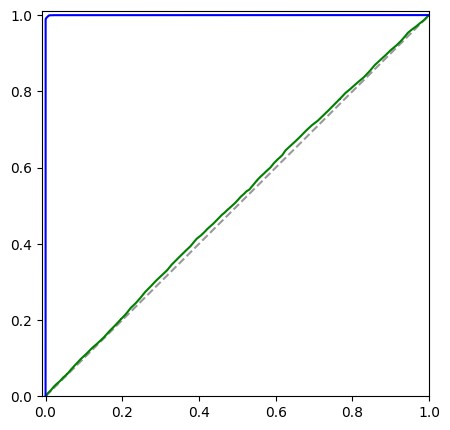

In [29]:
plt.figure(figsize=(5,5))

plt.plot([0,1], [0,1], 'k--', alpha=.4)

tpr, fpr, _ = roc_curve(y_test, scores_test)
plt.plot(tpr, fpr, 'g')

tpr, fpr, _ = roc_curve(y_train, scores_train)
plt.plot(tpr, fpr, 'b')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);

### A handmade attack: the scalar product between the features

In [30]:
hm_scores = []

for target_index, tm in enumerate(threat_model):
    _, labels = tm.generate_training_samples(num_train+num_test)
    for synth_data_index, _ in enumerate(_):
        score = synthetic_features[synth_data_index,:] @ target_features[target_index,:]
        hm_scores.append(score)

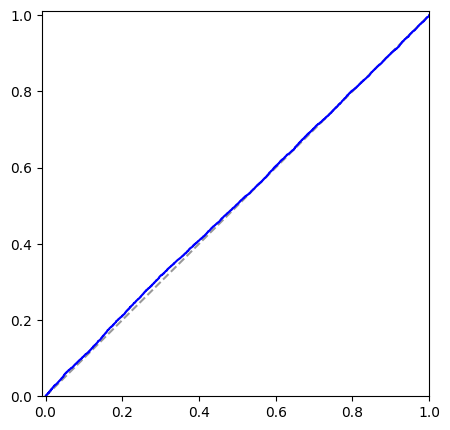

In [31]:
plt.figure(figsize=(5,5))

plt.plot([0,1], [0,1], 'k--', alpha=.4)

tpr, fpr, _ = roc_curve(y, hm_scores)
plt.plot(tpr, fpr, 'b')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);

### Compare with targeted attack

In [32]:
class KernelFeature(tapas.attacks.SetFeature):
    """Extract some features from a graph, using a specific kernel."""
    
    def __init__(self, kernel):
        self.kernel = kernel
    
    def fit(self, tudataset):
        """Fit the kernel used by this feature using a dataset."""
        self.kernel.fit(tudataset)
    
    def extract(self, datasets):
        return np.stack([
            self.kernel.transform(d).mean(axis=0)
            for d in datasets
        ])

In [39]:
attack = tapas.attacks.ShadowModellingAttack(
    tapas.attacks.ComposedGraphClassifier(
        classifier = RandomForestClassifier(),
        # Remove all memoization (this expects a grakel.Kernel).
        kernel = kernel.kernel
    ),
    label = 'ComposedAttack'
)

In [46]:
num_summaries = 10

summaries = []
for tm in tqdm.tqdm(threat_model, total=num_summaries):
    if len(summaries) >= num_summaries:
        continue
    attack.train(tm, num_samples=200)
    summaries.append(tm.test(attack, num_samples=200))

200it [14:46,  4.43s/it]                                                                   


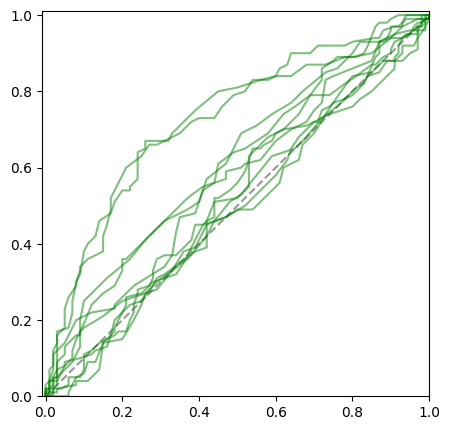

In [47]:
plt.figure(figsize=(5,5))

plt.plot([0,1], [0,1], 'k--', alpha=.4)

for summary in summaries:
    tpr, fpr, _ = roc_curve(summary.labels, summary.scores)
    plt.plot(tpr, fpr, 'g', alpha=.5)

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);